# Learning Curves

# Distance Matrix

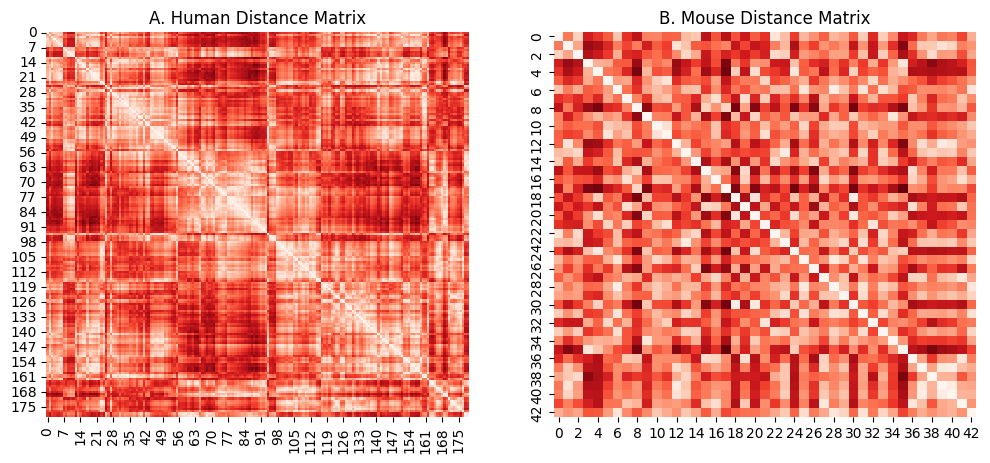

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load human and mouse distance/connectivity
human_conn = np.loadtxt("../src/data/human_LeftParcelGeodesicDistmat.txt")
mouse_conn = np.load("../src/data/mouse_ccf_isocortex_distance_matrix_sampled_43_no_first_row_col.npy")

# Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(human_conn, ax=axes[0], cmap="Reds", cbar=False)
axes[0].set_title("A. Human Distance Matrix")
sns.heatmap(mouse_conn, ax=axes[1], cmap="Reds", cbar=False)
axes[1].set_title("B. Mouse Distance Matrix")
plt.show()


# Graph visualization with area names

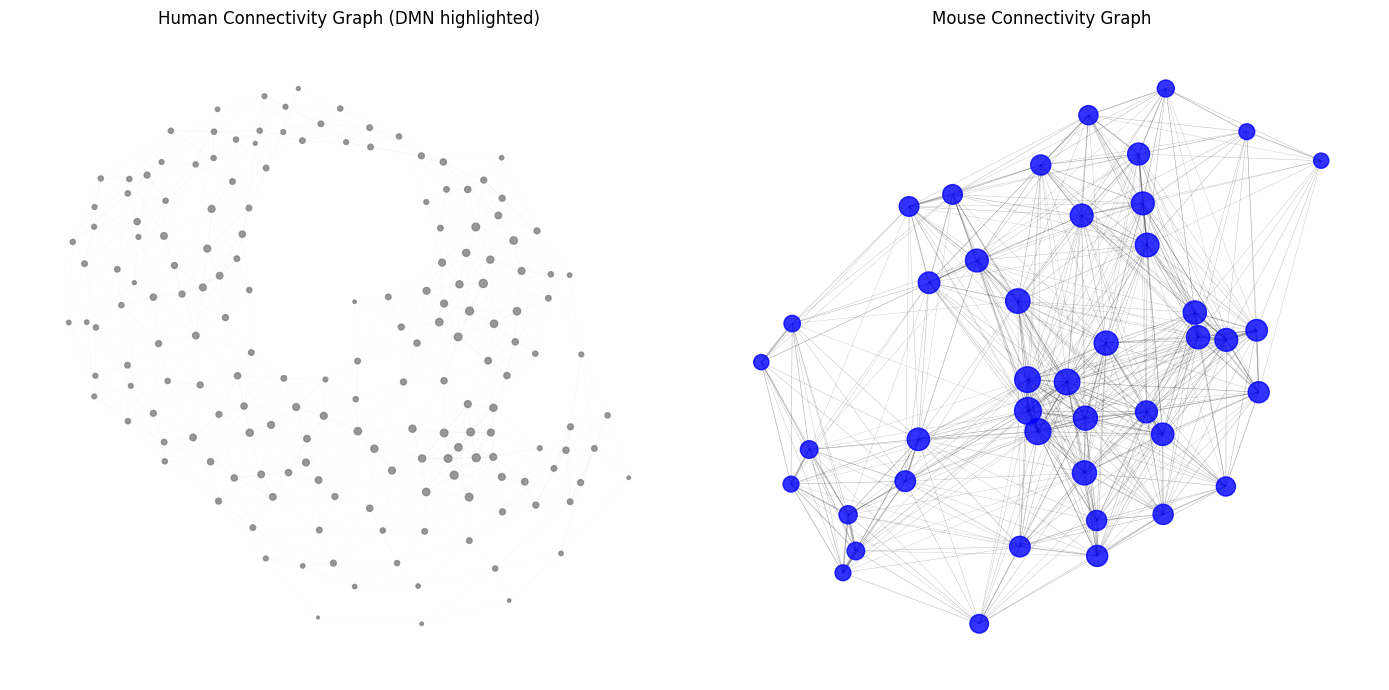

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Load area names
# ---------------------------
with open("../src/data/human_areaNamesGlasser180.txt") as f:
    human_areas = [line.strip() for line in f]

with open("../src/data/mouse_area_names.txt") as f:
    mouse_areas = [line.strip() for line in f]

# ---------------------------
# Load connectivity matrices
# ---------------------------
human_conn = np.loadtxt("../src/data/human_LeftParcelGeodesicDistmat.txt")
mouse_conn = np.load("../src/data/mouse_ccf_isocortex_distance_matrix_sampled_43_no_first_row_col.npy")

# ---------------------------
# Build graphs from matrices
# ---------------------------
def build_graph(matrix, labels, threshold=None):
    G = nx.Graph()
    for i, name in enumerate(labels):
        G.add_node(i, label=name)  # keep numeric IDs, store label as attr
    n = matrix.shape[0]
    for i in range(n):
        for j in range(i+1, n):
            w = matrix[i, j]
            if threshold is None or w < threshold:
                G.add_edge(i, j, weight=w)
    return G

G_human = build_graph(human_conn, human_areas, threshold=30)  # tweak threshold
G_mouse = build_graph(mouse_conn, mouse_areas, threshold=5)

# ---------------------------
# Relabel nodes with area names
# ---------------------------
human_graph = nx.relabel_nodes(G_human, {i: area for i, area in enumerate(human_areas)})
mouse_graph = nx.relabel_nodes(G_mouse, {i: area for i, area in enumerate(mouse_areas)})

# ---------------------------
# Load DMN areas (for human)
# ---------------------------
with open("../src/data/dmn_areas.txt") as f:
    dmn_areas = [line.strip() for line in f]

# ---------------------------
# Layouts
# ---------------------------
pos_human = nx.kamada_kawai_layout(human_graph)
pos_mouse = nx.kamada_kawai_layout(mouse_graph)

# ---------------------------
# Centrality for node size
# ---------------------------
deg_human = dict(nx.degree(human_graph))
deg_mouse = dict(nx.degree(mouse_graph))

node_sizes_human = [deg_human[n]*2 for n in human_graph.nodes()]
node_sizes_mouse = [deg_mouse[n]*10 for n in mouse_graph.nodes()]  # scaled up (fewer nodes)

# ---------------------------
# Node colors (DMN red, else gray)
# ---------------------------
node_colors_human = ["red" if n in dmn_areas else "gray" for n in human_graph.nodes()]
node_colors_mouse = ["blue"] * len(mouse_graph.nodes())  # all blue (unless DMN mapping exists)

# ---------------------------
# Edge weights (inverse distance = stronger)
# ---------------------------
def get_edge_weights(G):
    weights = []
    for u, v, d in G.edges(data=True):
        w = d.get("weight", 1.0)
        weights.append(1.0 / (w+1e-5))  # inverse to make small distances = thick edges
    return weights

edge_weights_human = get_edge_weights(human_graph)
edge_weights_mouse = get_edge_weights(mouse_graph)

# ---------------------------
# Draw plots
# ---------------------------
plt.figure(figsize=(14, 7))

# Human graph
plt.subplot(1, 2, 1)
nx.draw_networkx_nodes(human_graph, pos_human,
                       node_color=node_colors_human,
                       node_size=node_sizes_human,
                       alpha=0.8)
nx.draw_networkx_edges(human_graph, pos_human,
                       width=edge_weights_human,
                       alpha=0.2)
plt.title("Human Connectivity Graph (DMN highlighted)", fontsize=12)
plt.axis("off")

# Mouse graph
plt.subplot(1, 2, 2)
nx.draw_networkx_nodes(mouse_graph, pos_mouse,
                       node_color=node_colors_mouse,
                       node_size=node_sizes_mouse,
                       alpha=0.8)
nx.draw_networkx_edges(mouse_graph, pos_mouse,
                       width=edge_weights_mouse,
                       alpha=0.3)
plt.title("Mouse Connectivity Graph", fontsize=12)
plt.axis("off")

plt.tight_layout()
plt.show()


# Activity

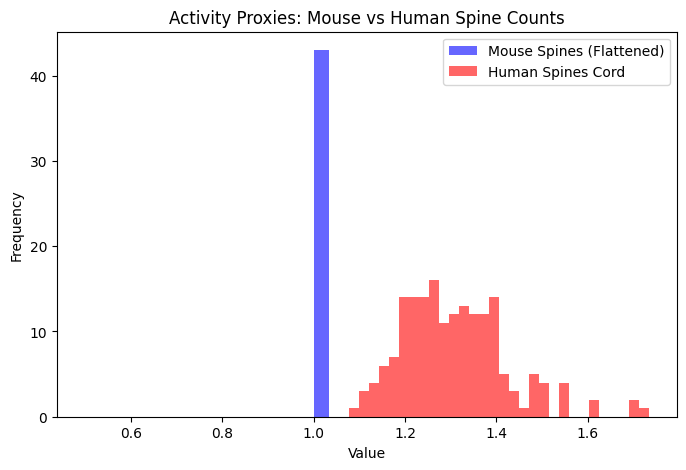

In [ ]:
import scipy.io as sio

# Load spine counts (mouse) and myelin (human)
mouse_spine = sio.loadmat("../src/data/mouse_spine_counts.mat")
human_myelin = sio.loadmat("../src/data/human_myelin_HCP_vec.mat")

# Extract arrays (check dict keys!)
mouse_spine_counts = mouse_spine[list(mouse_spine.keys())[-1]].flatten()
human_myelin_vec = human_myelin[list(human_myelin.keys())[-1]].flatten()

# Compare distributions
plt.figure(figsize=(8,5))
plt.hist(mouse_spine_counts, bins=30, alpha=0.6, color="blue", label="Mouse Spines (Flattened)")
plt.hist(human_myelin_vec, bins=30, alpha=0.6, color="red", label="Human Spines Cord")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Activity Proxies: Mouse vs Human Spine Counts")
plt.legend()
plt.show()


# Scatter plot vs. connectivity strength

In [ ]:
import numpy as np
import scipy.io as sio

# --- Load connectivity matrices ---
human_conn = np.loadtxt("../src/data/human_LeftParcelGeodesicDistmat.txt")
mouse_conn = np.load("../src/data/mouse_ccf_isocortex_distance_matrix_sampled_43_no_first_row_col.npy")

# --- Average connectivity per region ---
avg_human_conn = human_conn.mean(axis=1)
avg_mouse_conn = mouse_conn.mean(axis=1)

print("avg_human_conn shape:", avg_human_conn.shape)
print("avg_mouse_conn shape:", avg_mouse_conn.shape)

# --- Load activity proxies ---
mouse_spine = sio.loadmat("../src/data/mouse_spine_counts.mat")
human_myelin = sio.loadmat("../src/data/human_myelin_HCP_vec.mat")

# check what variables exist inside .mat
print("mouse_spine keys:", mouse_spine.keys())
print("human_myelin keys:", human_myelin.keys())


avg_human_conn shape: (180,)
avg_mouse_conn shape: (43,)
mouse_spine keys: dict_keys(['__header__', '__version__', '__globals__', 'mouse_spine_counts'])
human_myelin keys: dict_keys(['__header__', '__version__', '__globals__', 'myelin_parcels_mean'])


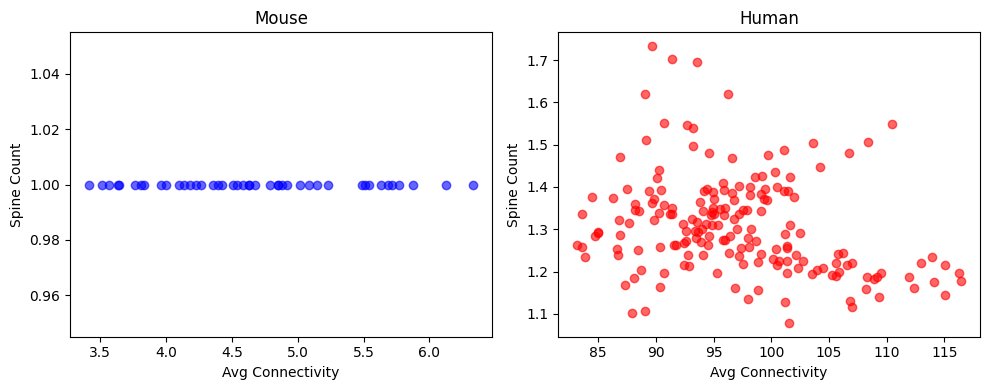

In [4]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# --- Load connectivity ---
human_conn = np.loadtxt("../src/data/human_LeftParcelGeodesicDistmat.txt")
mouse_conn = np.load("../src/data/mouse_ccf_isocortex_distance_matrix_sampled_43_no_first_row_col.npy")

avg_human_conn = human_conn.mean(axis=1)
avg_mouse_conn = mouse_conn.mean(axis=1)

# --- Load activity proxies ---
mouse_spine_counts = sio.loadmat("../src/data/mouse_spine_counts.mat")['mouse_spine_counts'].flatten()
human_myelin_vec = sio.loadmat("../src/data/human_myelin_HCP_vec.mat")['myelin_parcels_mean'].flatten()

# --- Align lengths (take min) ---
N_mouse = min(len(avg_mouse_conn), len(mouse_spine_counts))
avg_mouse_conn = avg_mouse_conn[:N_mouse]
mouse_spine_counts = mouse_spine_counts[:N_mouse]

N_human = min(len(avg_human_conn), len(human_myelin_vec))
avg_human_conn = avg_human_conn[:N_human]
human_myelin_vec = human_myelin_vec[:N_human]

# --- Scatter plots ---
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.scatter(avg_mouse_conn, mouse_spine_counts, color="blue", alpha=0.6)
plt.xlabel("Avg Connectivity")
plt.ylabel("Spine Count")
plt.title("Mouse")

plt.subplot(122)
plt.scatter(avg_human_conn, human_myelin_vec, color="red", alpha=0.6)
plt.xlabel("Avg Connectivity")
plt.ylabel("Spine Count")
plt.title("Human")

plt.tight_layout()
plt.show()
